# Plotting sea ice in the Southern Ocean
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import os
from dask.distributed import Client

The following modules are used in map creation.

In [2]:
import cmocean as cm                              # Nice colormaps
import cftime                                     # In case you need to work with time axes
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps

## Accessing model outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 12)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

## Accessing ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [5]:
#Saving name of experiments of interest in variables that can be easily referred to
exp = "01deg_jra55v140_iaf_cycle2"
#Name (short name) of variable of interest
varInt = "aice" #sea ice concentration

Optional variables, activate if needed. Note that because times need correction, **the start time is actually one month after the month we are interested in**. See below for explanation.

In [6]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-02' for i in range(2000, 2001, 1)]
#End date
etime = [str(i)+'-01' for i in range(2001, 2002, 1)]
#Define frequency. Remember to check frequency and variable of interest are related to each other, for example, aice_m has a monthly frequency, while aice has a daily frequency.
freq = '1 daily'

## Defining functions

**Accessing ACCESS-OM2-01 outputs**  
Defining function that loads data automatically using `cc.querying.getvar()` in a loop. The inputs needed are similar to those for the `cc.querying.getvar()` function, with the addition of inputs to define an area of interest.  
The `getACCESSdata` will achieve the following:  
- Access data for the experiment and variable of interest at the frequency requested and within the time frame specified  
- Apply **time corrections** as midnight (00:00:00) is interpreted differently by the CICE model and the xarray package.
    - CICE reads *2010-01-01 00:00:00* as the start of 2010-01-01, while xarray interprets it as the start of the following day (2010-01-02). To fix this problem, 12 hours are subtracted from the time dimension (also known as *time coordinate*).  
- Latitude and longitude will be corrected in the dataset using the `geolon_t` dataset. The coordinate names are replaced by names that are more intuitive.  
- Minimum and maximum latitudes and longitudes can be specified in the function to access specific areas of the dataset if required.  The **Southern Ocean** is defined as ocean waters south of 45S.

In [7]:
#Accessing corrected longitude data to update geographical coordinates in the array of interest
geolon_t = cc.querying.getvar(exp, 'geolon_t', session, n = -1)

#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, exp = exp, freq = freq, ses = session, minlon = geolon_t.yt_ocean.values.min(), maxlon = geolon_t.yt_ocean.values.max(),\
                  minlat = geolon_t.xt_ocean.values.min(), maxlat = geolon_t.xt_ocean.values.max()):
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end)
    #Applying time correction 
    vararray['time'] = vararray.time - dt.timedelta(hours = 12)
    # assign new coordinates to SST dataset 
    #.coords extracts the values of the coordinate specified in the brackets
    vararray.coords['ni'] = geolon_t['xt_ocean'].values
    vararray.coords['nj'] = geolon_t['yt_ocean'].values
    #Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
    vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #Subsetting data to area of interest
    #Subsetting sea ice concentration array
    vararray = vararray.sel(yt_ocean = slice(minlon, maxlon))
    return vararray

## Applying functions
A variety of plots showing sea ice area changes in the Southern Ocean will be created below and saved in a folder using years of data shown in the graph as a unique identifier.

The `aice_m` variable gives the mean monthly concentration of ice in a cell. In other words, this represents the monthly mean proportion of ice found in a given grid cell. To calculate the area covered by ice, the area of each cell is needed.  
The area is saved as `area_t` and it is given by the ocean model, below we will load it to the notebook and multiply it by `aice_m` to get the total ice area.

In [8]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = cc.querying.getvar(exp, 'area_t', session, n = 1)
#Accessing ACCESS 0.1deg outputs for the entire time range of interest
SO = getACCESSdata(varInt, stime[0], etime[-1], minlon = -90, maxlon = -50, freq = freq)

## Sea ice seasonality calculations
The code below has been 'translated' from the `calc_ice_season` which is part of the `aceecostats` package developed by Michael Sumner at AAD. This section calculates annual sea ice advance and retreat as defined by Massom et al 2013 [DOI:10.1371/journal.pone.0064756]. If a pixel has at least 15% of sea ice concentration for five consecutive days, sea ice is considered to be advancing at that pixel. Day of retreat is the time when concentration remains below 15% until the end of the year.

In [13]:
#Threshold refers to 15% sea ice concentration
thres = 0.15
#Refers to the number of consecutive days ice concentration needs to be over 15% to be considered as advancing
ndays = 3#Temporarily changing to 3 from 5
#How many timesteps within a year are we evaluating
timesteps = len(SO.time.values)

#If sea ice concentration is equal or more than threshold, then set to True, otherwise set to False
threshold = SO.where(SO < thres, other = True).where(SO >= thres, other = False)
#Add values through time to get total of days with ice cover of at least 15% within a pixel
rsum = threshold.sum('time')

#Create masks
#If time sums are zero set to True, otherwise set to False
alllt = rsum.where(rsum != 0, True).where(rsum == 0, False)
#If time sums are the same to timesteps in analysis set to True, otherwise set to False
allgt = rsum.where(rsum != timesteps, True).where(rsum == timesteps, False)

#Apply masks to threshold
threshold.coords['mask_alllt'] = (('yt_ocean', 'xt_ocean'), alllt)
threshold.coords['mask_allgt'] = (('yt_ocean', 'xt_ocean'), allgt)

#Calculate a running mean on masked data
RunMean = threshold.where(threshold.mask_alllt == False).where(threshold.mask_allgt == False).rolling(time = ndays, min_periods = 2).mean()
#Turn it into boolean If running mean is 1 set to True, otherwise set to False
RunMean = RunMean.where(RunMean == 1, False).where(RunMean != 1, True)
#Change all values in first timstep to True
RunMean[0].values = np.ones(RunMean[0].shape, dtype = bool)

#Apply new mask to threshold
masked_threshold = threshold.where(threshold.mask_alllt == False).where(threshold.mask_allgt == False).where(RunMean == True)
#Add all values and change pixels with no sea ice over 15% concentration to nan and all pixels with sea ice over 15% during entire duration to total timesteps
SeaIceAdv = masked_threshold.sum('time').where(alllt == False, np.nan).where(allgt == False, timesteps)

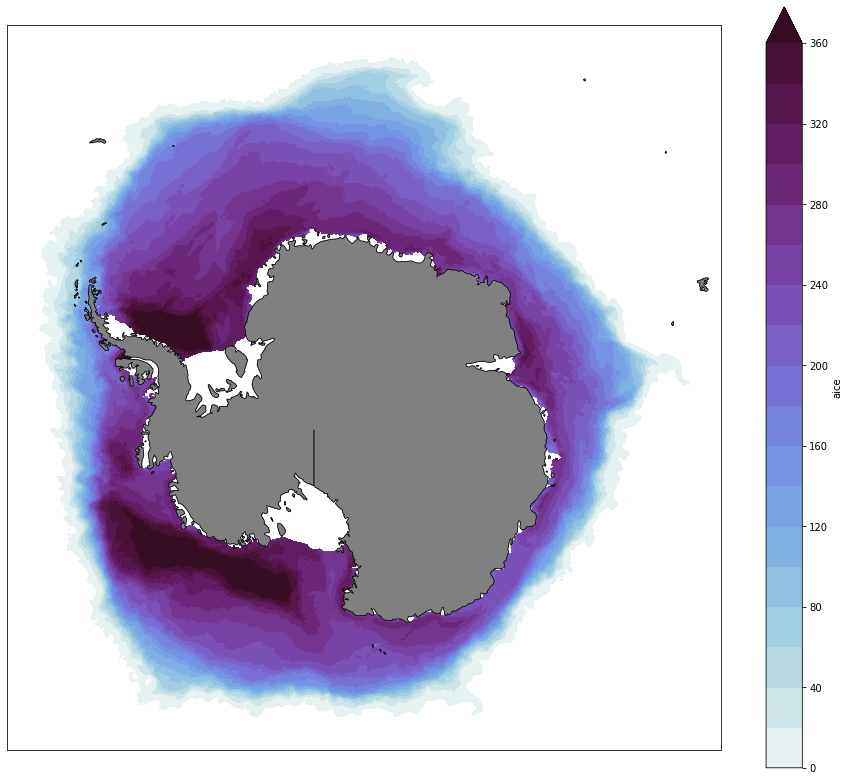

In [17]:
#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Define levels for contours
levels = np.arange(0, timesteps+1, 20)

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Create composite figures
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 14), subplot_kw = dict(projection = projection))
#Create counter using a list: i and j define the plot, while season refers to season
p1 = SeaIceAdv.plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes, 
              #Setting scientific palette as color palette and defining min-max values for colourbar
              cmap = cm.cm.dense, levels = levels,
              transform = ccrs.PlateCarree())
axes.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
axes.add_feature(land_50m)